In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

In [2]:
# --- load 
df = pd.read_csv("Clean_Dataset.csv") 
if "Unnamed: 0" in df.columns: 
    df.drop("Unnamed: 0", axis=1, inplace=True)

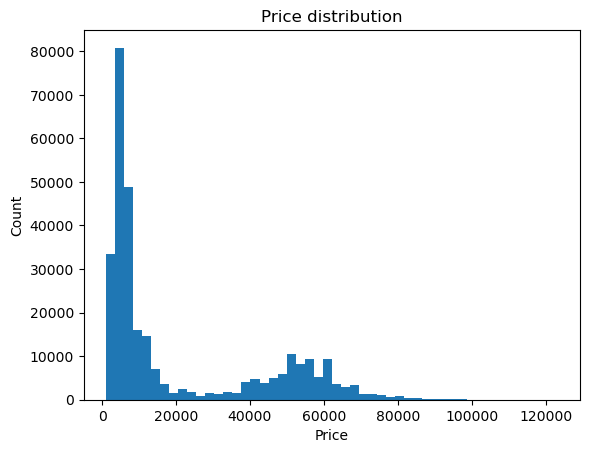

In [3]:
plt.hist(df['price'], bins=50)
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [4]:
X = df.drop("price", axis=1) 
y = df["price"]

In [5]:
# numeric and categorical columns
numcols = ['days_left', 'duration'] 
catcols = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

In [6]:
#Preprocessing pipeline
preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numcols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), catcols)
], remainder="drop")

In [7]:
#Xgboost pipeline
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("regressor", TransformedTargetRegressor(regressor=xgb, func=np.log1p, inverse_func=np.expm1))
])

In [8]:
#Random Forest pipeline
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("regressor", TransformedTargetRegressor(regressor=rf, func=np.log1p, inverse_func=np.expm1))
])

In [9]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Fit
xgb_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
#predict
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

In [11]:
y_test = pd.to_numeric(y_test)
y_pred_xgb = pd.to_numeric(y_pred_xgb)
y_pred_rf = pd.to_numeric(y_pred_rf)

#Metrics
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

print("Test set metrics:")
print("XGBoost:", regression_metrics(y_test, y_pred_xgb))
print("RandomForest:", regression_metrics(y_test, y_pred_rf))

Test set metrics:
XGBoost: {'MAE': 1683.5738525390625, 'RMSE': np.float64(3220.066458941492), 'R2': 0.9798851609230042}
RandomForest: {'MAE': 1047.185599833375, 'RMSE': np.float64(2765.633285259708), 'R2': 0.9851619971030595}


In [ ]:
scoring = {"neg_mae": "neg_mean_absolute_error", "neg_mse": "neg_mean_squared_error", "r2": "r2"}
cv_xgb = cross_validate(xgb_pipeline, X, y, cv=5, scoring=scoring, return_train_score=False)
cv_rf = cross_validate(rf_pipeline, X, y, cv=5, scoring=scoring, return_train_score=False)

def summarize_cv(cv_res):
    mae_mean = -np.mean(cv_res["test_neg_mae"])
    mse_mean = -np.mean(cv_res["test_neg_mse"])
    rmse_mean = np.sqrt(mse_mean)
    r2_mean = np.mean(cv_res["test_r2"])
    return {"MAE_mean": mae_mean, "RMSE_mean": rmse_mean, "R2_mean": r2_mean}

print("\n5-fold CV results:")
print("XGBoost CV:", summarize_cv(cv_xgb))
print("RandomForest CV:", summarize_cv(cv_rf))

In [ ]:
n = 100
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:n], label="Actual", linewidth=2)
plt.plot(y_pred_rf[:n], label="Random Forest", linestyle="--")
plt.plot(y_pred_xgb[:n], label="XGBoost", linestyle="--")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices (First 100 Samples)")
plt.legend()
plt.show()